In [3]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from helper import plot_missing_values
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

**Exploring the datasets**

Genres dataset has 164 lines and 4 features.
Echonest dataset has 11440 lines and 8 features.
Tracks dataset has 99995 lines and 13 features.
Spectral dataset has 99995 lines and 21 features.
NA values in each column of genres dataset:
genre_parent_id    13
dtype: int64
NA values in each column of echonest dataset:
danceability     19
speechiness     150
valence          21
dtype: int64
NA values in each column of tracks dataset:
album_title           911
artist_latitude     59788
artist_longitude    59788
genre_top           55362
title                   1
dtype: int64
NA values in each column of spectral dataset:
Series([], dtype: int64)


/var/folders/8w/3lg80w9149zg21tlm57prt_00000gp/T/ipykernel_87157/4206925099.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')
/var/folders/8w/3lg80w9149zg21tlm57prt_00000gp/T/ipykernel_87157/4206925099.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')
/var/folders/8w/3lg80w9149zg21tlm57prt_00000gp/T/ipykernel_87157/4206925099.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')


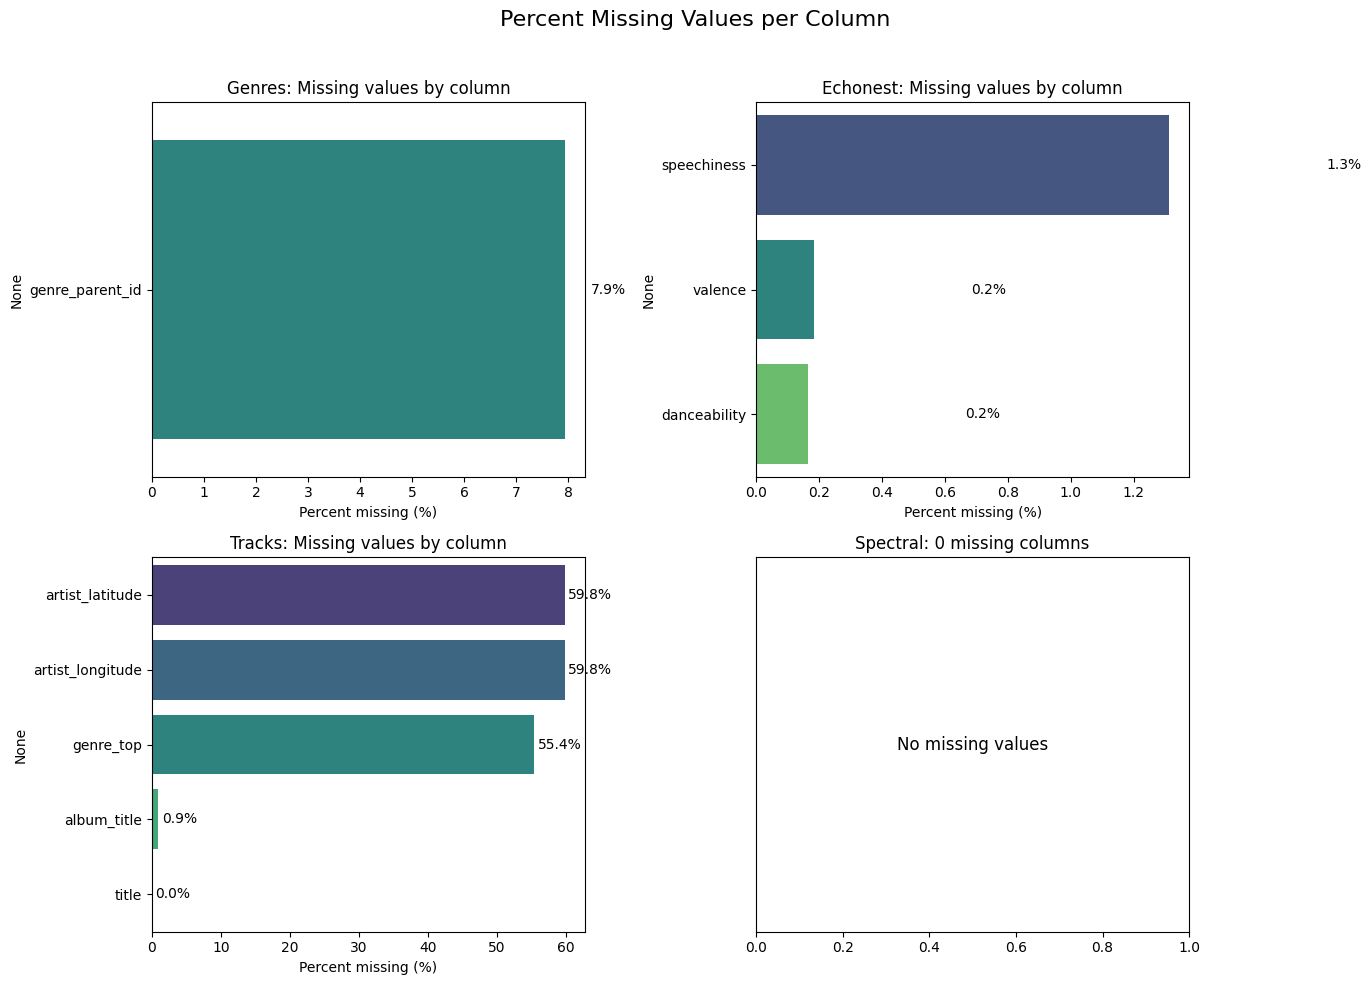

In [4]:
# Explore different datasets
# Load the genres dataset
genres_path = os.path.join('data', 'genres.csv')
genres = pd.read_csv(genres_path)

echonest_path = os.path.join('data', 'echonest_features.tsv')
echonest = pd.read_csv(echonest_path, sep='\t')

tracks_path = os.path.join('data', 'tracks.tsv')
tracks = pd.read_csv(tracks_path, sep='\t')

spectral_path = os.path.join('data', 'spectral_features.tsv')
spectral = pd.read_csv(spectral_path, sep='\t')

genres_n_features = genres.shape[1] - 1  # Exclude the label column
genres_n_lines = genres.shape[0]

print(f"Genres dataset has {genres_n_lines} lines and {genres_n_features} features.")

echonest_n_features = echonest.shape[1] - 1
echonest_n_lines = echonest.shape[0]

print(f"Echonest dataset has {echonest_n_lines} lines and {echonest_n_features} features.")

tracks_n_features = tracks.shape[1] - 1
tracks_n_lines = tracks.shape[0]

print(f"Tracks dataset has {tracks_n_lines} lines and {tracks_n_features} features.")

spectral_n_features = spectral.shape[1] - 1
spectral_n_lines = spectral.shape[0]

print(f"Spectral dataset has {spectral_n_lines} lines and {spectral_n_features} features.")


# Explore the NA values 
na_counts = genres.isna().sum()
print("NA values in each column of genres dataset:")
print(na_counts[na_counts > 0])

na_counts_echonest = echonest.isna().sum()
print("NA values in each column of echonest dataset:")
print(na_counts_echonest[na_counts_echonest > 0])

na_counts_tracks = tracks.isna().sum()
print("NA values in each column of tracks dataset:")
print(na_counts_tracks[na_counts_tracks > 0])       

na_counts_spectral = spectral.isna().sum()
print("NA values in each column of spectral dataset:")
print(na_counts_spectral[na_counts_spectral > 0])

# Clearer plots for missing values: percent missing per column
datasets = {'Genres': genres, 'Echonest': echonest, 'Tracks': tracks, 'Spectral': spectral}
plt.figure(figsize=(14, 10))
for i, (name, df) in enumerate(datasets.items(), 1):
    plt.subplot(2, 2, i)
    # percent of missing values by column (0-100)
    na_pct = df.isna().mean() * 100
    na_pct = na_pct[na_pct > 0].sort_values(ascending=False)
    if na_pct.empty:
        plt.text(0.5, 0.5, 'No missing values', ha='center', va='center', fontsize=12)
        plt.title(f'{name}: 0 missing columns')
        plt.xlabel('')
        plt.yticks([])
    else:
        sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')
        plt.xlabel('Percent missing (%)')
        plt.title(f'{name}: Missing values by column')
        # annotate bars with percent values
        for j, v in enumerate(na_pct.values):
            plt.text(v + 0.5, j, f'{v:.1f}%', va='center')
plt.suptitle('Percent Missing Values per Column', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [5]:
# We re going to build a model to predict the genre_top
# The datset we re going to use is a merge of tracks['genre_top', genres, genre_all] and genres[genre_id,genre_handle,genre_parent_id,genre_title]
# We need to substitute the titles with ids in the genres dataset to be able to merge them

genres_id = genres[['genre_id', 'genre_parent_id', 'genre_title']]

# This is afunction that takes a colomn where features are titles and replace them with their corresponding ids from the genres_id

def replace_titles_with_ids(df, column, genres_id):
    title_to_id = dict(zip(genres_id['genre_title'], genres_id['genre_id']))
    df[column] = df[column].map(title_to_id)
    return df

# print(tracks['genre_top'])

replace_titles_with_ids(tracks, 'genre_top', genres_id)
# print(tracks)

# Turn the values in genre_top to int 
tracks['genre_top'] = tracks['genre_top'].astype('Int64')
# print(tracks['genre_top'].dtype)
# print(tracks)

# save the tracks_id dataset 
tracks.to_csv('data/tracks_id.tsv', sep='\t', index=False)


In [6]:
# Now we re going to construct a dataset where genres are titles and not numbers 
# We can use the genres_id dataset to map back the genre_top ids to titles

from collections.abc import Iterable
import ast

def replace_ids_with_titles(df, column, genres_id):
    id_to_title = dict(zip(genres_id['genre_id'], genres_id['genre_title']))
    df = df.copy()

    def map_ids(x):
        # treat iterables (lists, tuples, sets, etc.) as collections of ids
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            return [id_to_title.get(i) for i in x]
        # treat scalars (single id) as one id
        return id_to_title.get(x, x)

    df[column] = df[column].apply(map_ids)
    return df

tracks['genres'] = tracks['genres'].apply(ast.literal_eval)
tracks['genres_all'] = tracks['genres_all'].apply(ast.literal_eval)


# print the type of the values in 'genres' column
print(tracks['genres'].apply(type).unique())
print(tracks['genres_all'].apply(type).unique())

tracks_titles = replace_ids_with_titles(tracks.copy(), 'genre_top', genres_id)
tracks_titles = replace_ids_with_titles(tracks_titles, 'genres', genres_id)
tracks_titles = replace_ids_with_titles(tracks_titles, 'genres_all', genres_id)

tracks_titles.to_csv('data/tracks_titles.tsv', sep='\t', index=False)


[<class 'list'>]
[<class 'list'>]


In [7]:
# test the function

# build the mapping, the parent should be a root node, see root_nodes
# We should keep going up the tree until we reach a root node
mapping_genre_parent = {}

parent_lookup = dict(zip(genres['genre_id'], genres['genre_parent_id']))

for gid in genres['genre_id']:
    current = gid
    parent = parent_lookup.get(current)

    while True:

        # Stop if parent is NaN
        if pd.isna(parent):
            break

        # Stop if parent points to itself (self-loop)
        if parent == current:
            break

        # Otherwise climb one level
        current = parent
        parent = parent_lookup.get(current)

    # current is now a root or self-parent
    mapping_genre_parent[gid] = current


# shape of unique values in mapping_genre_parent
print(len(set(mapping_genre_parent.values())))



14


In [8]:
# Define a function for filling the NA values of top genre using this strategy
# 1. if there is a dominant parent in genres, aka has more occurrences or more occurences of his sons, then we assign the parent as top genre
# 2. else we do the same to genres_all
# 3. else we choose randomly from the root genres in genres list
# if the parent is na in the mapping, then the parent is himself

def fill_top_genre(df, parent_genre_map):
    import random
    df = df.copy()

    # Identify root genres (parent = itself)
    # root_genres = [gid for gid, root in parent_genre_map.items() if gid == root]

    for idx, row in df.iterrows():

        # Ad a treatment for rows where the genre_top is not na
        # we make sure they refer to the root parent and not the child
        if not pd.isna(row['genre_top']):
            gid = row['genre_top']
            root_parent = parent_genre_map.get(gid, gid)
            df.at[idx, 'genre_top'] = root_parent
            continue

        # Only fill missing values
        if pd.isna(row['genre_top']):

            # ----------------------------------------------------
            # STEP 1: Dominant parent in genres
            # ----------------------------------------------------
            genre_counts = {}
            if isinstance(row['genres'], list):
                for gid in row['genres']:
                    parent = parent_genre_map.get(gid)
                    if parent is not None:
                        genre_counts[parent] = genre_counts.get(parent, 0) + 1

            if genre_counts:
                df.at[idx, 'genre_top'] = max(genre_counts, key=genre_counts.get)
                continue

            # ----------------------------------------------------
            # STEP 2: Dominant parent in genres_all
            # ----------------------------------------------------
            genre_all_counts = {}
            if isinstance(row['genres_all'], list):
                for gid in row['genres_all']:
                    parent = parent_genre_map.get(gid)
                    if parent is not None:
                        genre_all_counts[parent] = genre_all_counts.get(parent, 0) + 1

            if genre_all_counts:
                df.at[idx, 'genre_top'] = max(genre_all_counts, key=genre_all_counts.get)
                continue

            # ----------------------------------------------------
            # STEP 3: Use first available genre (genres, then genres_all)
            # ----------------------------------------------------
            genres_list = row['genres'] if isinstance(row['genres'], list) else []
            genres_all_list = row['genres_all'] if isinstance(row['genres_all'], list) else []

            # If both empty: drop row
            if len(genres_list) == 0 and len(genres_all_list) == 0:
                df = df.drop(index=idx)
                continue

            # Else pick first valid gid
            if len(genres_list) > 0:
                first_gid = genres_list[0]
            else:
                first_gid = genres_all_list[0]

            root_parent = parent_genre_map.get(first_gid, first_gid)
            df.at[idx, 'genre_top'] = root_parent

    return df




In [9]:
tracks_filled = fill_top_genre(tracks, mapping_genre_parent)
print(tracks_filled['genre_top'].isna().sum())

0


In [10]:
# save the filled dataset
tracks_filled.to_csv('data/tracks_filled.tsv', sep='\t', index=False)

/Users/aya/Supervised_Challenge/helper.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')
/Users/aya/Supervised_Challenge/helper.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')
/Users/aya/Supervised_Challenge/helper.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')


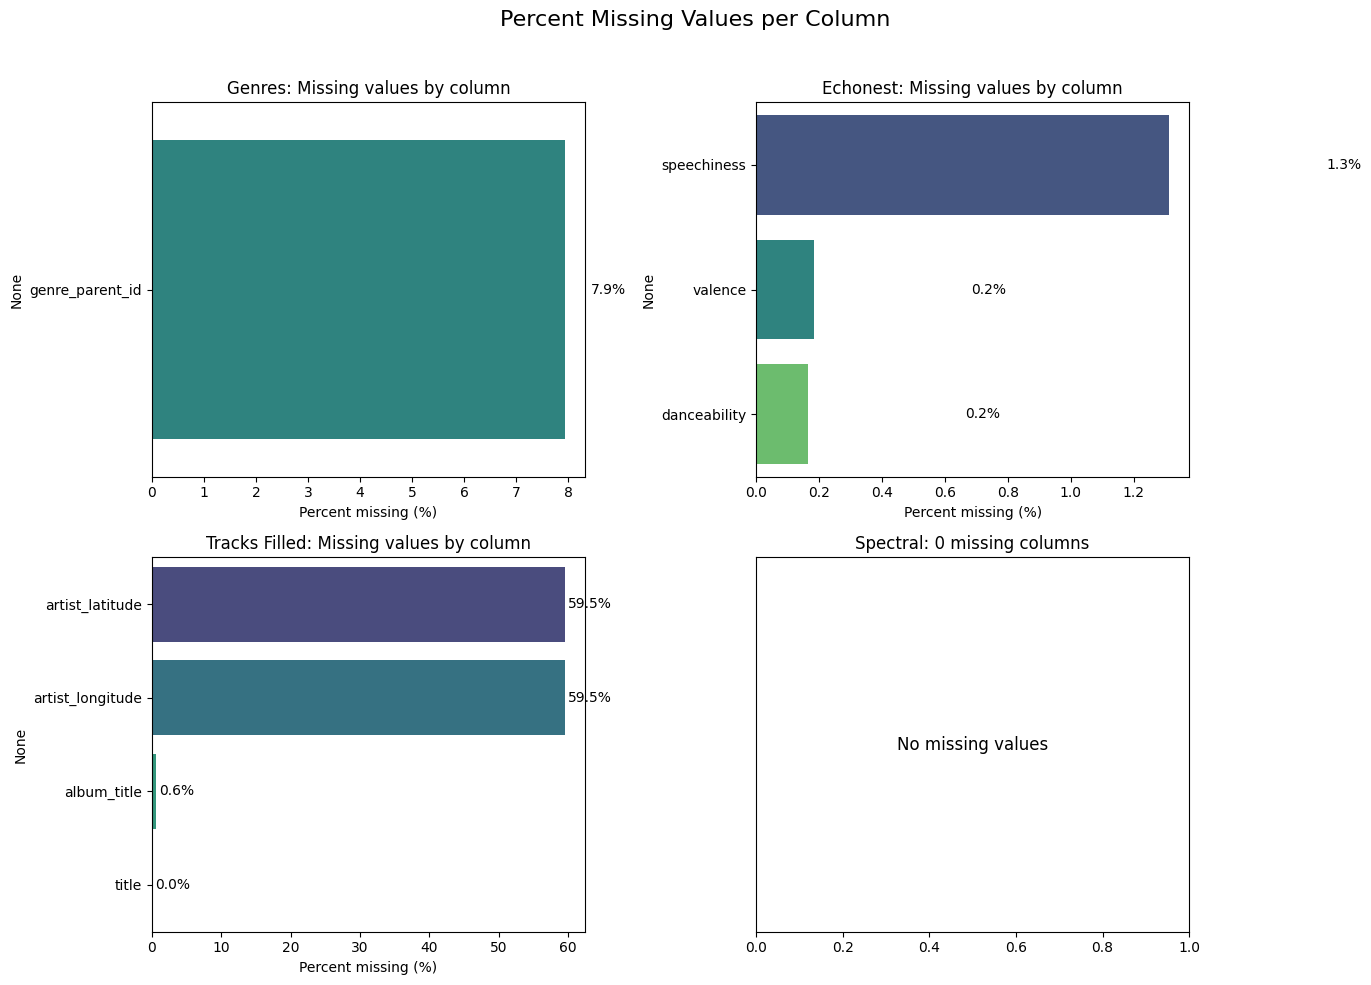

In [11]:
datasets = {'Genres': genres, 'Echonest': echonest, 'Tracks Filled': tracks_filled, 'Spectral': spectral}
plot_missing_values(datasets)

In [12]:
# Merging the datasets
# the 1st merge between tracks_filled and spectral_features on 'track_id'

# Remove the na values in tracks_filled in album_title and title features before merging
tracks_filled = tracks_filled.dropna(subset=['album_title', 'title'])

tracks_spectral = pd.merge(tracks_filled, spectral, on='track_id', how='left')

# The 2nd merge between tracks_spectral and echonest_features on 'track_id'
tracks_echonest = pd.merge(echonest, tracks_spectral, on='track_id', how='inner')

In [13]:
#Suppression des valeurs manquantes dans artist_latitude et artist_longitude
tracks_echonest['artist_location_unknown'] = np.where(
    tracks_echonest['artist_latitude'].isnull(), 
    1, 
    0
)
tracks_echonest['artist_latitude'] = tracks_echonest['artist_latitude'].fillna(0)
tracks_echonest['artist_longitude'] = tracks_echonest['artist_longitude'].fillna(0)
tracks_echonest.to_csv('data/tracks_echonest.tsv', sep='\t', index=False)

tracks_spectral['artist_location_unknown'] = np.where(
    tracks_spectral['artist_latitude'].isnull(), 
    1, 
    0
)
tracks_spectral['artist_latitude'] = tracks_spectral['artist_latitude'].fillna(0)
tracks_spectral['artist_longitude'] = tracks_spectral['artist_longitude'].fillna(0)
tracks_spectral.to_csv('data/tracks_spectral.tsv', sep='\t', index=False)


/Users/aya/Supervised_Challenge/helper.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')
/Users/aya/Supervised_Challenge/helper.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')


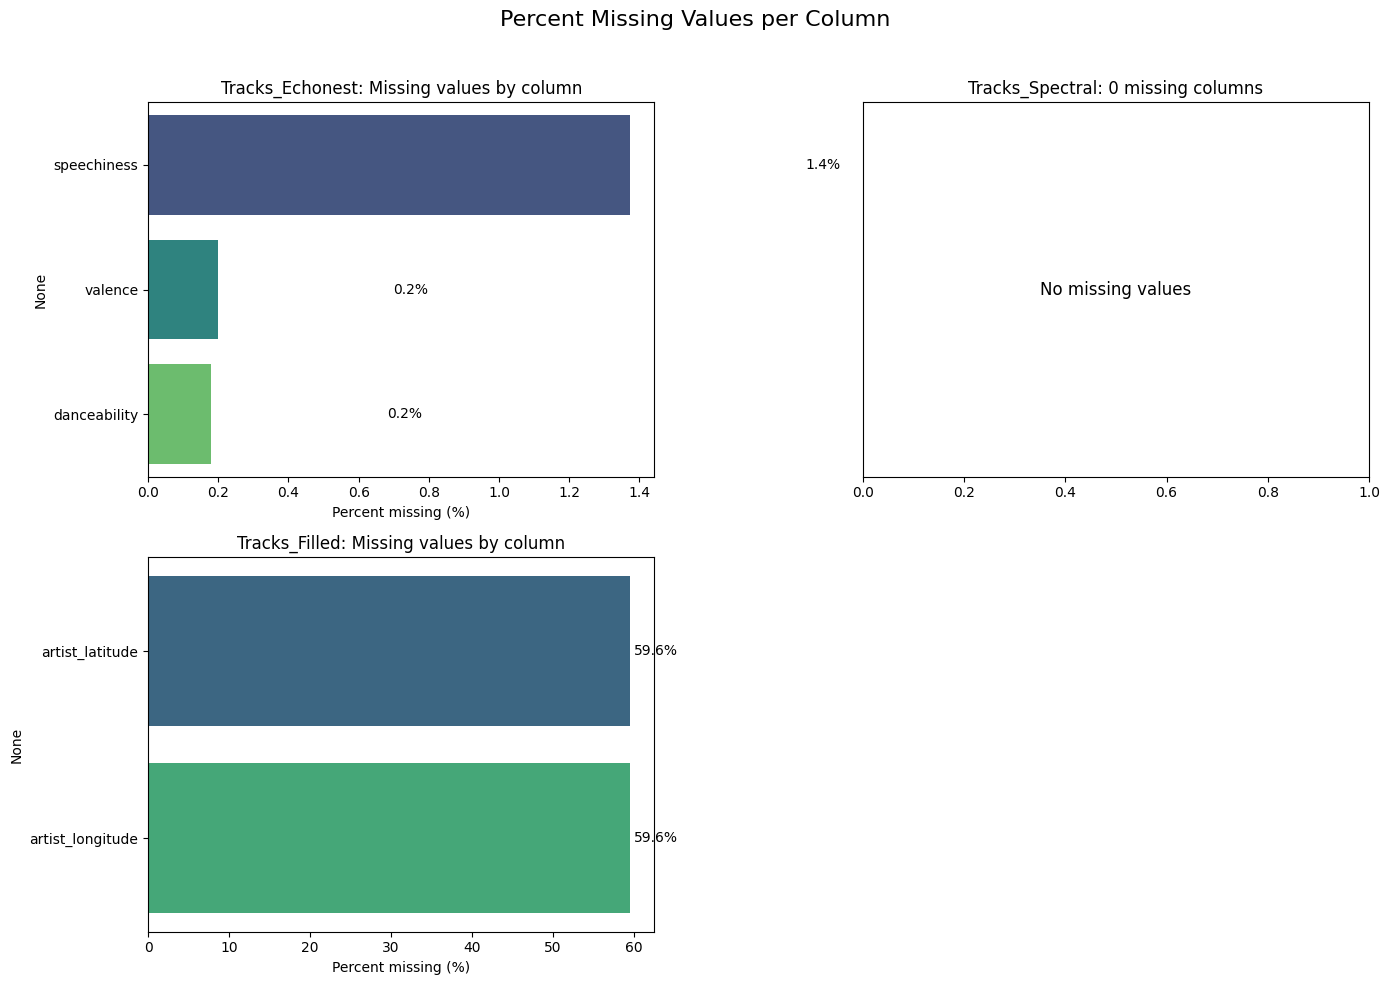

In [14]:
# Plot the missing values
datasets = {'Tracks_Echonest': tracks_echonest, 'Tracks_Spectral': tracks_spectral, 'Tracks_Filled': tracks_filled}

plot_missing_values(datasets)

In [15]:
# remove the lines with missing values in Tracks_Spectral
tracks_spectral = tracks_spectral.dropna()
tracks_spectral.to_csv('data/tracks_spectral.tsv', sep='\t', index=False)
# print the missing values after cleaning
print(tracks_spectral.isna().sum())

track_id                          0
album_title                       0
album_tracks                      0
artist_latitude                   0
artist_longitude                  0
artist_name                       0
duration                          0
favorites                         0
genre_top                         0
genres                            0
genres_all                        0
interest                          0
listens                           0
title                             0
spectral_bandwidth_kurtosis_01    0
spectral_bandwidth_max_01         0
spectral_bandwidth_mean_01        0
spectral_bandwidth_median_01      0
spectral_bandwidth_min_01         0
spectral_bandwidth_skew_01        0
spectral_bandwidth_std_01         0
spectral_centroid_kurtosis_01     0
spectral_centroid_max_01          0
spectral_centroid_mean_01         0
spectral_centroid_median_01       0
spectral_centroid_min_01          0
spectral_centroid_skew_01         0
spectral_centroid_std_01    

In [16]:
# Now we re going to construct datasets where genres are titles and not numbers
# datasets eith no mention of _title have ids for all genres, genres_all, genre_top

tracks_filled_titles = replace_ids_with_titles(tracks_filled.copy(), 'genre_top', genres_id)
tracks_filled_titles = replace_ids_with_titles(tracks_filled_titles, 'genres', genres_id)
tracks_filled_titles = replace_ids_with_titles(tracks_filled_titles, 'genres_all', genres_id)

tracks_filled_titles.to_csv('data/tracks_filled_titles.tsv', sep='\t', index=False)

tracks_echonest_titles = replace_ids_with_titles(tracks_echonest.copy(), 'genre_top', genres_id)
tracks_echonest_titles = replace_ids_with_titles(tracks_echonest_titles, 'genres', genres_id)
tracks_echonest_titles = replace_ids_with_titles(tracks_echonest_titles, 'genres_all', genres_id)

tracks_echonest_titles.to_csv('data/tracks_echonest_titles.tsv', sep='\t', index=False)

tracks_spectral_titles = replace_ids_with_titles(tracks_spectral.copy(), 'genre_top', genres_id)
tracks_spectral_titles = replace_ids_with_titles(tracks_spectral_titles, 'genres', genres_id)
tracks_spectral_titles = replace_ids_with_titles(tracks_spectral_titles, 'genres_all', genres_id)

tracks_spectral_titles.to_csv('data/tracks_spectral_titles.tsv', sep='\t', index=False)


In [17]:
numeric_cols = tracks_echonest.select_dtypes(include=['number']).columns

# Exclure les colonnes qui ne doivent PAS être utilisées (comme id)
numeric_cols = [c for c in numeric_cols if c not in ['track_id', 'id']]
print("=== STATISTIQUES DESCRIPTIVES ===")

numeric_cols = echonest.select_dtypes(include=['number']).columns
numeric_cols = [c for c in numeric_cols if c not in ['track_id', 'id']]

print(tracks_echonest[numeric_cols].describe())



=== STATISTIQUES DESCRIPTIVES ===
       acousticness  danceability        energy  instrumentalness  \
count  1.055200e+04  10533.000000  10552.000000      10552.000000   
mean   4.893387e-01      0.506814      0.541701          0.628827   
std    3.847772e-01      0.189796      0.274762          0.366886   
min    9.491000e-07      0.051435      0.000020          0.000000   
25%    7.086072e-02      0.367386      0.330238          0.265446   
50%    4.865710e-01      0.512027      0.554599          0.832358   
75%    8.976159e-01      0.651317      0.774281          0.915124   
max    9.957965e-01      0.968645      0.999964          0.998016   

           liveness   speechiness         tempo       valence  
count  10552.000000  10407.000000  10552.000000  10531.000000  
mean       0.185582      0.098310    122.446269      0.449566  
std        0.153467      0.133854     34.928135      0.276186  
min        0.025916      0.022324      0.000000      0.008695  
25%        0.100224     

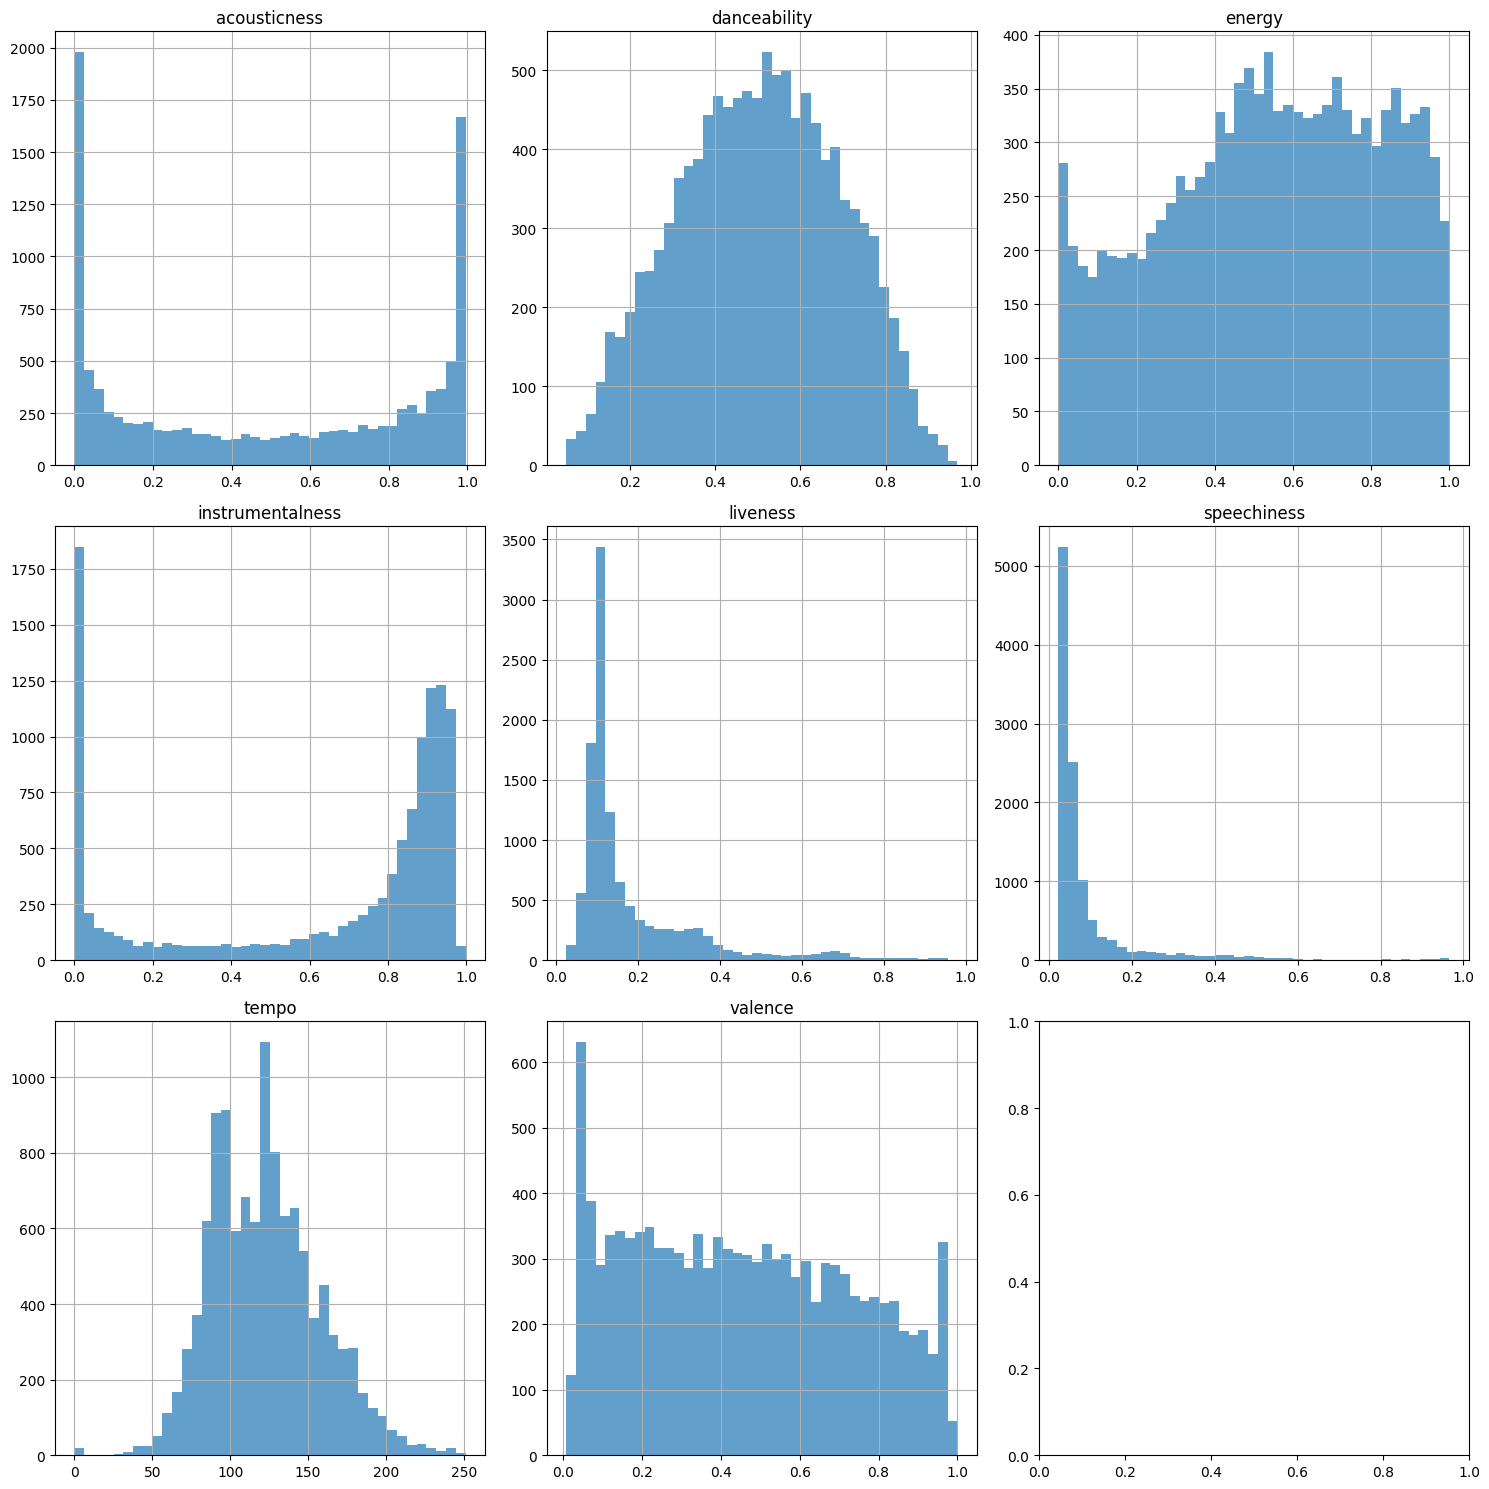

In [18]:
import math
import matplotlib.pyplot as plt

numeric_cols = echonest.select_dtypes(include=['number']).columns
numeric_cols = [c for c in numeric_cols if c not in ['track_id']]

n = len(numeric_cols)
rows = math.ceil(n/3)

fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    echonest[col].hist(bins=40, ax=axes[i], alpha=0.7)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


=== STATISTIQUES DESCRIPTIVES (Spectral) ===
       spectral_bandwidth_kurtosis_01  spectral_bandwidth_max_01  \
count                    99995.000000               99995.000000   
mean                         7.588260                3544.781941   
std                         28.517327                 384.217742   
min                         -1.961655                 469.536530   
25%                         -0.074174                3361.957397   
50%                          1.396075                3555.611572   
75%                          5.662101                3703.081299   
max                       3143.452148                5495.584473   

       spectral_bandwidth_mean_01  spectral_bandwidth_median_01  \
count                99995.000000                  99995.000000   
mean                  1408.089600                   1362.269289   
std                    463.258008                    509.942550   
min                     20.130140                      0.000000   
25%    

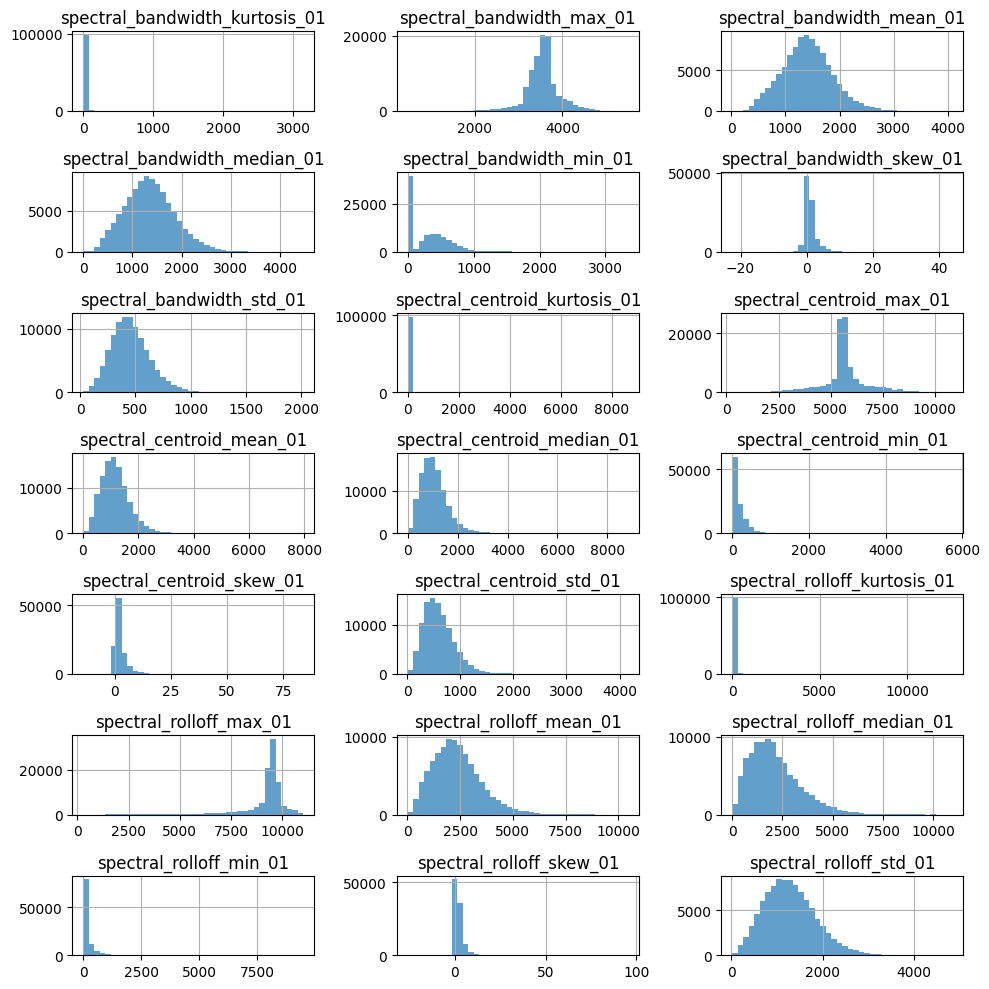

In [19]:
numeric_cols = spectral.select_dtypes(include=['number']).columns
numeric_cols = [c for c in numeric_cols if c not in ['track_id', 'id']]

print("=== STATISTIQUES DESCRIPTIVES (Spectral) ===")
print(spectral[numeric_cols].describe())
import math
fig, axes = plt.subplots(math.ceil(len(numeric_cols)/3), 3, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    spectral[col].hist(bins=40, ax=axes[i], alpha=0.7)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


=== 15 FEATURES AUX PLUS FAIBLES VARIANCES ===
                           feature      variance
30         artist_location_unknown      0.240813
14      spectral_bandwidth_skew_01      3.442173
21       spectral_centroid_skew_01      8.717562
28        spectral_rolloff_skew_01      9.085672
5                        favorites    195.562324
2                  artist_latitude    526.600937
9   spectral_bandwidth_kurtosis_01    829.852514
1                     album_tracks   1630.066657
3                 artist_longitude   2036.018016
16   spectral_centroid_kurtosis_01  11014.029329
23    spectral_rolloff_kurtosis_01   15226.33359
6                        genre_top  29823.088474
15       spectral_bandwidth_std_01  31960.933888
20        spectral_centroid_min_01  41662.755288
4                         duration  80291.460846


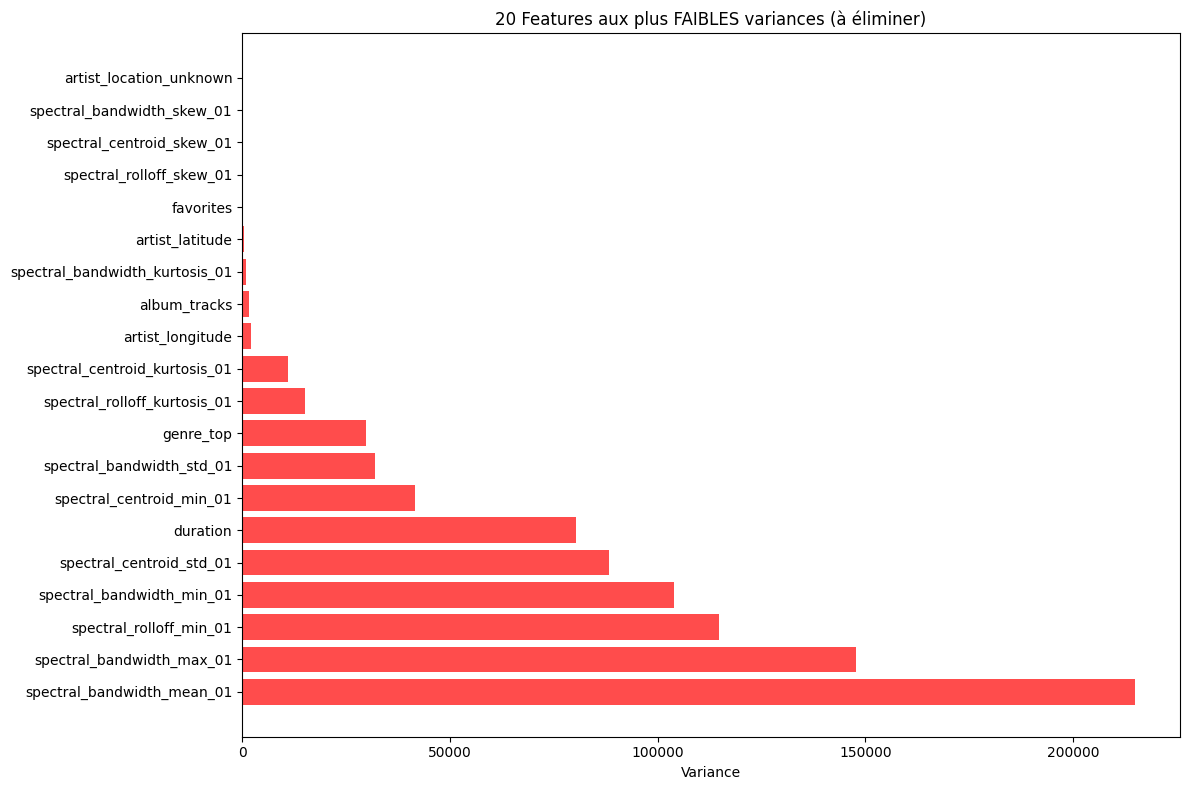


Features à éliminer (variance < 1): 1
['artist_location_unknown']


In [20]:
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

# Colonnes numériques uniquement
X = tracks_spectral.select_dtypes(include=[float, int])

# Calculer toutes les variances
variances = X.var()

# DataFrame trié par variance CROISSANTE (les plus faibles en 1er)
variance_df = pd.DataFrame({
    'feature': variances.index,
    'variance': variances.values
}).sort_values('variance', ascending=True)  # ← Les plus faibles d'abord

print("=== 15 FEATURES AUX PLUS FAIBLES VARIANCES ===")
print(variance_df.head(15))

# Graphique des 20 plus faibles
plt.figure(figsize=(12, 8))
plt.barh(range(20), variance_df.head(20)['variance'], color='red', alpha=0.7)
plt.yticks(range(20), variance_df.head(20)['feature'])
plt.xlabel('Variance')
plt.title('20 Features aux plus FAIBLES variances (à éliminer)')
plt.gca().invert_yaxis()  # Plus faibles en haut
plt.tight_layout()
plt.show()

# Seuil pour éliminer (exemple: variance < 1)
low_var_threshold = 1
low_var_features = variance_df[variance_df['variance'] < low_var_threshold]['feature'].tolist()
print(f"\nFeatures à éliminer (variance < {low_var_threshold}): {len(low_var_features)}")
print(low_var_features)


                                album_tracks  artist_latitude  \
album_tracks                        1.000000        -0.125698   
artist_latitude                    -0.125698         1.000000   
artist_longitude                    0.093433        -0.327597   
duration                           -0.094785        -0.001734   
favorites                          -0.031480        -0.003913   
genre_top                           0.129699        -0.047754   
interest                           -0.010075        -0.005183   
listens                            -0.012586        -0.026331   
spectral_bandwidth_kurtosis_01      0.029806        -0.131971   
spectral_bandwidth_max_01           0.031366         0.006077   
spectral_bandwidth_mean_01         -0.049074         0.075166   
spectral_bandwidth_median_01       -0.054981         0.072485   
spectral_bandwidth_min_01          -0.017971         0.030012   
spectral_bandwidth_skew_01          0.078372        -0.124626   
spectral_bandwidth_std_01

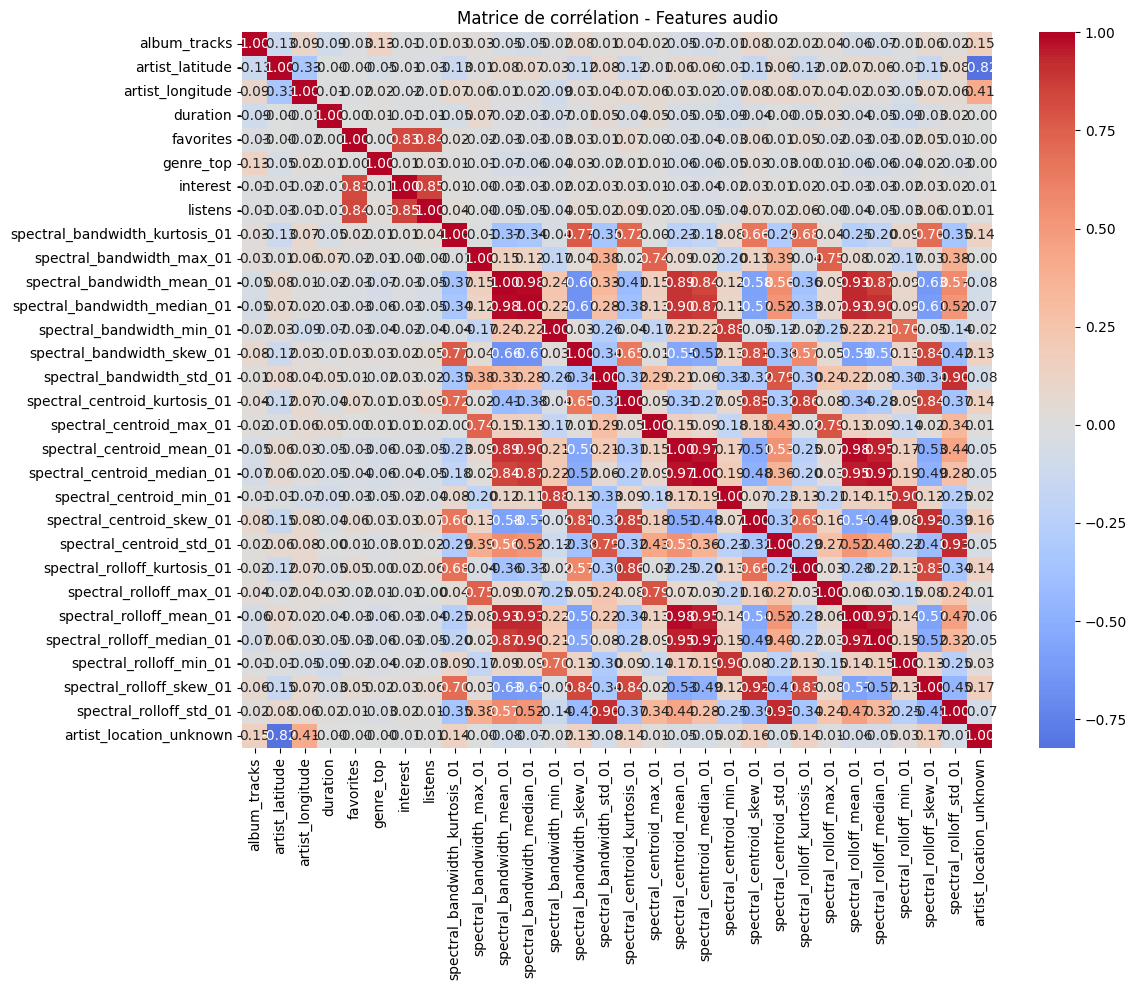

In [21]:
numeric_cols = tracks_spectral.select_dtypes(include=['number']).columns
numeric_cols = [c for c in numeric_cols if c not in ['track_id', 'id']]
corr_matrix = tracks_echonest[numeric_cols].corr()
print(corr_matrix)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matrice de corrélation - Features audio')
plt.tight_layout()
plt.show()

In [22]:
#group avec correlation entre élts > 0.98
group1=['spectral_bandwidth_median_01','spectral_bandwidth_mean_01']
group2=['spectral_centroid_median_01','spectral_centroid_mean_01']
group3=['spectral_rolloff_median_01','spectral_rolloff_mean_01']
#on supprime les variables redondantes 
to_drop = [
    'spectral_bandwidth_median_01',
    'spectral_centroid_median_01',
    'spectral_rolloff_median_01'  
]
tracks_spectral_reduced = tracks_spectral.drop(columns=to_drop)
#group avec correlation entre élts > 0.85
group4=['spectral_rolloff_mean_01','spectral_bandwidth_mean_01','spectral_centroid_mean_01']
group5=['interest','listens','favorites']
#goup avec correllation >0.65
group6=['spectral_bandwidth_skew_01','spectral_centroid_kurtosis_01','spectral_bandwidth_kurtosis_01','spectral_centroid_skew_01','spectral_rolloff_skew_01',
        'spectral_rolloff_kurtosis_01']

In [23]:

def pca_group(df, cols, name):
    Xg = df[cols].dropna()
    scaler = StandardScaler()
    Xg_scaled = scaler.fit_transform(Xg)

    pca = PCA()           # toutes les composantes
    pca.fit(Xg_scaled)

    cum_var = np.cumsum(pca.explained_variance_ratio_)
    print(f"\nGroupe {name} ({len(cols)} variables)")
    print("Variance expliquée par composante :", pca.explained_variance_ratio_)
    print("Variance cumulée :", cum_var)

# 2) Appliquer PCA sur chaque groupe et afficher variance
pca_group(tracks_spectral_reduced, group4, "4 (moyennes spectrales)")
pca_group(tracks_spectral_reduced, group5, "5 (popularité)")
pca_group(tracks_spectral_reduced, group6, "6 (skew/kurtosis)")


Groupe 4 (moyennes spectrales) (3 variables)
Variance expliquée par composante : [0.95413426 0.04030683 0.00555891]
Variance cumulée : [0.95413426 0.99444109 1.        ]

Groupe 5 (popularité) (3 variables)
Variance expliquée par composante : [0.88420548 0.05947391 0.05632061]
Variance cumulée : [0.88420548 0.94367939 1.        ]

Groupe 6 (skew/kurtosis) (6 variables)
Variance expliquée par composante : [0.70772249 0.13650326 0.09028994 0.0425328  0.01720451 0.005747  ]
Variance cumulée : [0.70772249 0.84422575 0.93451569 0.97704849 0.994253   1.        ]


In [24]:

def make_pcs(df, cols, n_comp, prefix):
    Xg = df[cols].dropna()
    scaler = StandardScaler()
    Xg_scaled = scaler.fit_transform(Xg)
    pca = PCA(n_components=n_comp)
    Z = pca.fit_transform(Xg_scaled)
    for j in range(n_comp):
        df.loc[Xg.index, f'{prefix}_pc{j+1}'] = Z[:, j]
    return df

# group4 → 1 PC
tracks_spectral_reduced = make_pcs(tracks_spectral_reduced, group4, 1, 'g4')

# group5 → 1 PC
tracks_spectral_reduced = make_pcs(tracks_spectral_reduced, group5, 1, 'g5')

# group6 → 3 PC
tracks_spectral_reduced = make_pcs(tracks_spectral_reduced, group6, 3, 'g6')

# puis on supprime les colonnes originales de ces groupes
tracks_spectral_reduced = tracks_spectral_reduced.drop(columns=group4+group5+group6)


In [25]:
tracks_spectral_reduced.to_csv('data/tracks_spectral_reduced.csv')

In [26]:
tracks_spectral_reduced.columns

Index(['track_id', 'album_title', 'album_tracks', 'artist_latitude',
       'artist_longitude', 'artist_name', 'duration', 'genre_top', 'genres',
       'genres_all', 'title', 'spectral_bandwidth_max_01',
       'spectral_bandwidth_min_01', 'spectral_bandwidth_std_01',
       'spectral_centroid_max_01', 'spectral_centroid_min_01',
       'spectral_centroid_std_01', 'spectral_rolloff_max_01',
       'spectral_rolloff_min_01', 'spectral_rolloff_std_01',
       'artist_location_unknown', 'g4_pc1', 'g5_pc1', 'g6_pc1', 'g6_pc2',
       'g6_pc3'],
      dtype='object')